Generate 200 terms and run it on LO, RI, Rand as starting point.
Then run a new reward mod env with different configurations, look at results.
Reward distributions (test_1): 1:10, 1:11
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=200)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT)) / RANDOM_AVERAGE_COUNT
             for term in tqdm(terms)]

100%|██████████| 202/202 [00:30<00:00,  6.54it/s]


In [3]:
print(f"Generated LO normalizable terms: {len(terms)}\n")
print(f"LO steps: {stepsLO}\n")
print(f"RI steps: {stepsRI}\n")
print(f"Rand steps: {stepsRand}\n")
print(f"LO max: {max(stepsLO)}")
print(f"RI max: {max(stepsRI)}")
print(f"Rand max: {max(stepsRand)}")

Generated LO normalizable terms: 202

LO steps: [20, 14, 4, 4, 35, 2, 7, 7, 9, 5, 1, 8, 16, 10, 87, 17, 4, 8, 4, 13, 5, 3, 9, 13, 26, 15, 31, 7, 2, 13, 21, 5, 7, 4, 12, 4, 7, 4, 32, 7, 6, 3, 0, 2, 5, 1, 12, 5, 14, 10, 4, 8, 5, 4, 6, 4, 3, 4, 3, 5, 8, 4, 5, 21, 3, 12, 1, 7, 4, 6, 8, 6, 10, 21, 6, 8, 94, 11, 16, 11, 11, 7, 15, 3, 6, 4, 2, 2, 4, 3, 5, 2, 14, 6, 15, 4, 5, 22, 9, 2, 3, 9, 4, 7, 3, 2, 6, 17, 5, 4, 3, 25, 6, 4, 18, 7, 6, 2, 2, 7, 4, 4, 4, 4, 7, 7, 8, 33, 8, 4, 6, 2, 4, 1, 5, 3, 1, 19, 17, 4, 2, 11, 6, 2, 2, 4, 2, 4, 2, 1, 3, 12, 5, 5, 24, 5, 21, 4, 5, 8, 9, 5, 3, 10, 4, 10, 13, 3, 3, 6, 1, 6, 3, 8, 1, 11, 33, 4, 4, 5, 3, 4, 3, 1, 7, 1, 9, 14, 3, 16, 7, 8, 25, 9, 17, 1, 3, 2, 4, 5, 12, 7]

RI steps: [21, 9, 7, 4, 13, 2, 6, 7, 12, 11, 11, 12, 17, 13, inf, 12, 4, 9, 8, 13, 16, 10, 15, 14, 14, 12, 25, 7, 6, 13, 22, 12, 7, 6, 18, 5, 6, 6, 23, 9, 33, 5, 0, 6, 6, 7, 6, 5, 10, 12, 5, 11, 5, 6, 6, 11, 6, 4, 4, 8, 8, 17, 5, 21, 5, 8, 6, 11, 4, 6, 18, 8, 12, 16, 7, 8, 29, 11, 18, 13, 14

In [4]:
max_count_steps_rlenv = 100
strategies_env = [LeftmostOutermostStrategy(), RightmostInnermostStrategy()]

explore_actions = 100
epsilon = 0.1

In [5]:
def experiment(reward_values=(-1, 0)):
    env = LambdaEnv(strategies=strategies_env,
                    lambda_terms=terms,
                    max_step_term=max_count_steps_rlenv,
                    count_terms=len(terms),
                    reward_values=(-1, 0))

    _, steps_env = \
        run_e_greedy_policy(environment=env,
                            exploration=explore_actions,
                            max_term_reward=max_count_steps_rlenv,
                            epsilon=epsilon,
                            deterministic=False,
                            is_action_based=True,
                            return_steps=True)
    print(f"Steps eg orig: {steps_env}")
    wh_orig = np.array(env.get_weights_history())

    comp_data = {
        "E-greedy n-d a-b": (clear_arr(steps_env), "-"),
        "LO": (clear_arr(stepsLO), "-"),
        "RI": (clear_arr(stepsRI), "-"),
        "Rand": (clear_arr(stepsRand), "-"),
    }
    draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum, reward {reward_values}")

    comp_data = {
        "LO-w": (wh_orig[:, 0], "-"),
        "RI-w": (wh_orig[:, 1], "-")
    }
    draw_mult_lines(comp_data, title=f"Strategy weights for reward {reward_values}",
                    x_label="step_no", y_label="prob")

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 7, 10, 5, 4, 13, 17, 10, 99, 16, 6, 9, 5, 13, 7, 4, 14, 19, 14, 19, 20, 7, 6, 13, 22, 5, 7, 4, 18, 5, 11, 6, 30, 8, 7, 5, 0, 5, 5, 6, 6, 5, 25, 19, 5, 8, 5, 6, 6, 11, 3, 4, 4, 5, 8, 5, 5, 21, 5, 12, 2, 10, 4, 6, 12, 6, 10, 28, 7, 8, 63, 11, 23, 19, 17, 8, 20, 9, 7, 4, 6, 6, 7, 3, 5, 2, 15, 7, 20, 4, 8, 19, 8, 3, 8, 9, 7, 8, 3, 2, 9, 18, 5, 7, 3, 14, 7, 6, 21, 7, 6, 2, 2, 9, 4, 10, 5, 4, 14, 11, 10, 26, 10, 5, 6, 6, 6, 1, 6, 4, 5, 18, 17, 7, 2, 12, 8, 5, 2, 4, 2, 4, 2, 1, 4, 13, 11, 5, 15, 5, 23, 4, 11, 13, 11, 8, 3, 12, 5, 14, 17, 4, 4, 6, 3, 6, 6, 9, 1, 12, 33, 5, 4, 7, 4, 4, 3, 1, 9, 1, 12, 13, 3, 29, 7, 11, 27, 9, 17, 1, 3, 3, 5, 5, 16, 7]


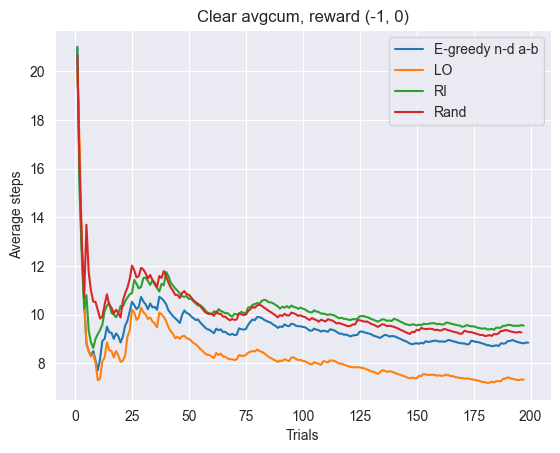

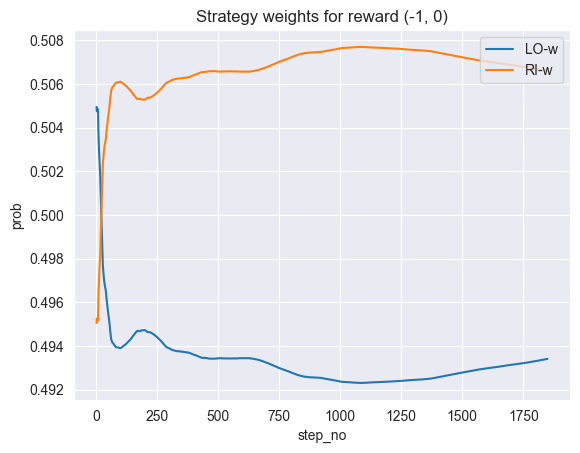

In [6]:
experiment(reward_values=(-1, 0))

# TEST 1

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 8, 10, 5, 5, 12, 17, 12, 99, 17, 4, 9, 7, 13, 7, 5, 10, 32, 17, 21, 25, 7, 5, 13, 22, 9, 7, 6, 18, 5, 11, 6, 29, 10, 15, 4, 0, 3, 6, 2, 15, 5, 19, 12, 5, 8, 5, 6, 6, 11, 3, 4, 4, 6, 8, 8, 5, 21, 5, 10, 1, 9, 4, 6, 12, 6, 10, 29, 7, 8, 63, 11, 27, 21, 17, 8, 20, 4, 9, 4, 2, 2, 7, 3, 5, 2, 11, 7, 21, 4, 8, 27, 9, 5, 6, 9, 6, 9, 3, 4, 10, 18, 5, 6, 3, 21, 7, 6, 20, 7, 6, 2, 3, 8, 4, 8, 4, 9, 10, 9, 10, 28, 10, 5, 6, 4, 4, 1, 6, 4, 1, 17, 17, 7, 3, 12, 8, 6, 4, 4, 2, 4, 2, 1, 5, 14, 6, 5, 14, 5, 28, 4, 9, 13, 11, 9, 3, 12, 5, 12, 15, 6, 4, 6, 1, 6, 5, 9, 1, 13, 32, 5, 5, 10, 4, 5, 3, 3, 12, 1, 13, 13, 3, 22, 7, 11, 27, 10, 17, 2, 4, 2, 5, 6, 16, 7]


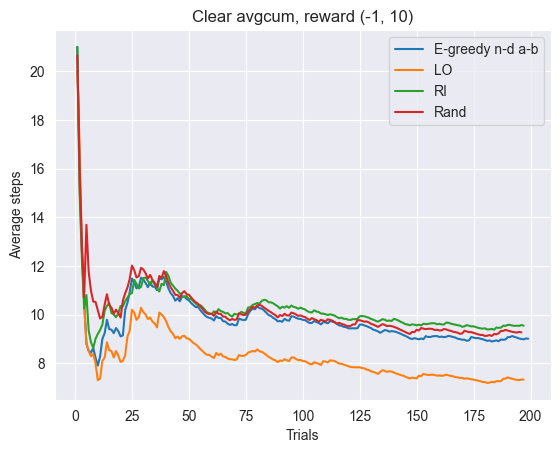

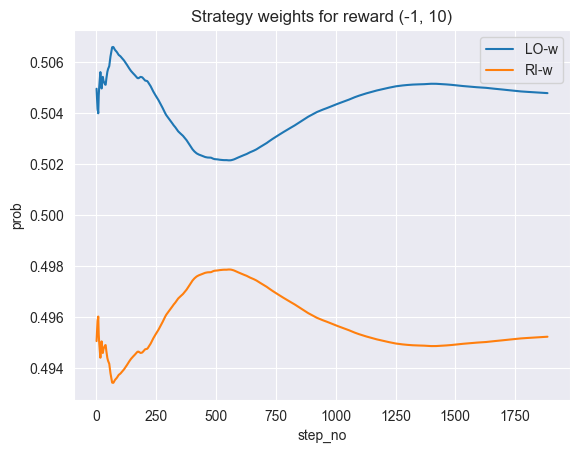

In [7]:
experiment(reward_values=(-1, 10))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 7, 9, 10, 2, 10, 17, 12, 99, 16, 4, 9, 5, 13, 8, 3, 13, 26, 14, 21, 25, 7, 4, 13, 22, 8, 7, 6, 18, 5, 9, 6, 36, 10, 13, 5, 0, 2, 5, 2, 13, 5, 19, 19, 5, 11, 5, 6, 6, 11, 3, 4, 4, 7, 8, 6, 5, 21, 5, 8, 1, 11, 4, 6, 14, 6, 10, 16, 7, 8, 74, 11, 19, 17, 15, 8, 20, 3, 9, 4, 6, 3, 5, 3, 5, 2, 16, 6, 26, 4, 13, 29, 6, 4, 5, 9, 6, 7, 3, 2, 12, 18, 5, 8, 3, 15, 7, 5, 21, 7, 6, 2, 2, 8, 4, 7, 4, 5, 10, 16, 10, 26, 11, 7, 6, 5, 6, 1, 6, 3, 2, 18, 17, 7, 3, 12, 7, 5, 3, 4, 2, 4, 2, 1, 4, 16, 6, 5, 14, 5, 23, 7, 6, 13, 11, 9, 3, 14, 4, 13, 22, 4, 4, 6, 2, 6, 6, 10, 1, 12, 31, 4, 4, 10, 3, 4, 3, 2, 12, 1, 12, 13, 3, 28, 7, 8, 26, 12, 17, 2, 4, 2, 7, 6, 16, 6]


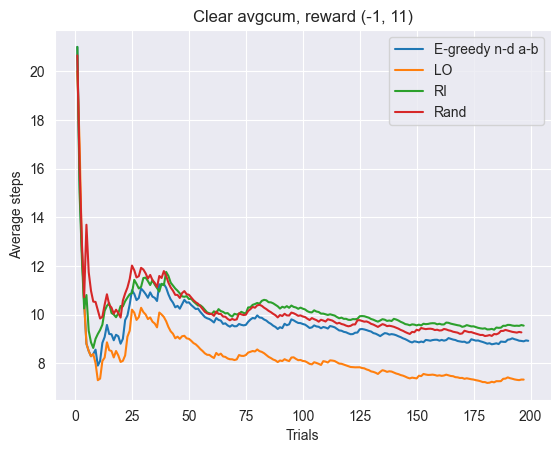

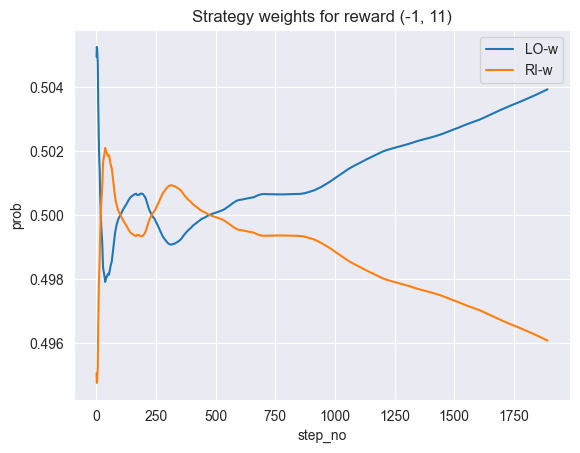

In [8]:
experiment(reward_values=(-1, 11))

# TEST 2
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 9, 10, 5, 1, 13, 17, 12, 99, 11, 4, 9, 6, 13, 7, 5, 15, 18, 26, 16, 34, 7, 3, 13, 22, 7, 7, 6, 19, 4, 9, 6, 38, 10, 10, 3, 0, 5, 6, 1, 10, 5, 20, 20, 5, 8, 5, 6, 6, 4, 4, 4, 4, 5, 8, 8, 5, 21, 4, 12, 2, 11, 4, 6, 17, 8, 10, 32, 7, 8, 63, 11, 24, 15, 16, 8, 20, 3, 7, 4, 4, 2, 4, 3, 5, 2, 13, 7, 19, 4, 7, 28, 8, 2, 5, 9, 6, 9, 3, 3, 9, 18, 5, 6, 3, 23, 7, 5, 22, 7, 7, 3, 4, 15, 4, 8, 4, 8, 14, 10, 10, 30, 8, 7, 6, 4, 4, 1, 6, 4, 2, 19, 17, 6, 2, 12, 6, 5, 4, 4, 2, 4, 2, 1, 5, 15, 9, 5, 14, 5, 24, 7, 11, 13, 11, 9, 3, 12, 5, 12, 19, 5, 4, 6, 1, 6, 8, 10, 1, 12, 33, 5, 4, 10, 3, 4, 3, 2, 12, 1, 11, 13, 3, 24, 7, 11, 25, 11, 17, 5, 3, 2, 4, 7, 16, 5]


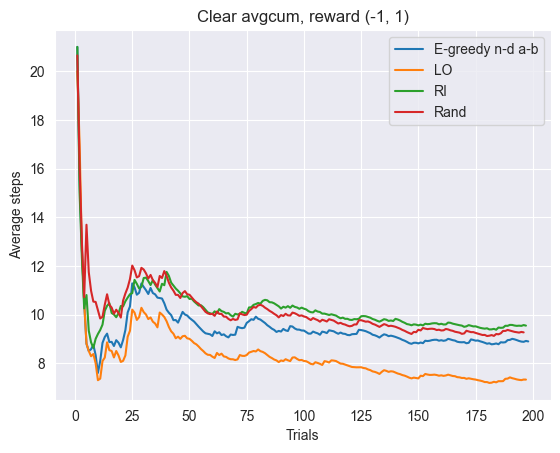

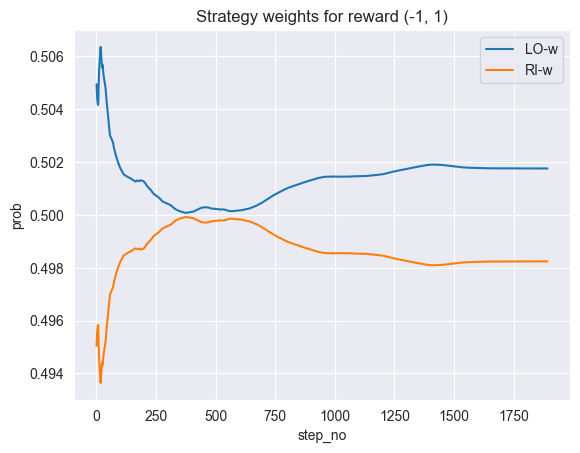

In [9]:
experiment(reward_values=(-1, 1))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 7, 10, 5, 1, 12, 17, 10, 99, 16, 5, 10, 7, 13, 7, 10, 13, 25, 28, 20, 34, 7, 6, 13, 22, 6, 7, 5, 18, 5, 10, 6, 35, 10, 13, 5, 0, 2, 6, 1, 6, 5, 15, 17, 4, 8, 5, 6, 6, 11, 7, 4, 4, 7, 8, 7, 5, 21, 5, 12, 1, 11, 4, 6, 17, 6, 10, 31, 7, 8, 63, 11, 24, 23, 17, 8, 20, 3, 9, 4, 4, 2, 4, 3, 5, 2, 12, 6, 24, 4, 6, 28, 9, 3, 6, 9, 6, 8, 3, 3, 8, 18, 5, 8, 3, 15, 7, 5, 21, 7, 7, 3, 3, 9, 4, 9, 4, 8, 13, 13, 10, 40, 8, 4, 6, 2, 5, 1, 6, 4, 2, 17, 17, 7, 2, 12, 7, 7, 6, 4, 2, 4, 2, 1, 3, 16, 12, 4, 16, 5, 22, 5, 10, 13, 11, 9, 3, 12, 4, 13, 17, 7, 4, 6, 2, 6, 7, 8, 1, 12, 32, 5, 5, 7, 3, 5, 4, 1, 9, 1, 12, 13, 3, 30, 7, 10, 29, 12, 17, 3, 4, 4, 4, 5, 16, 5]


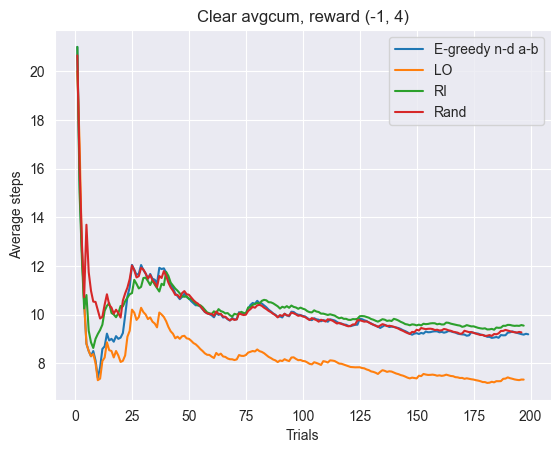

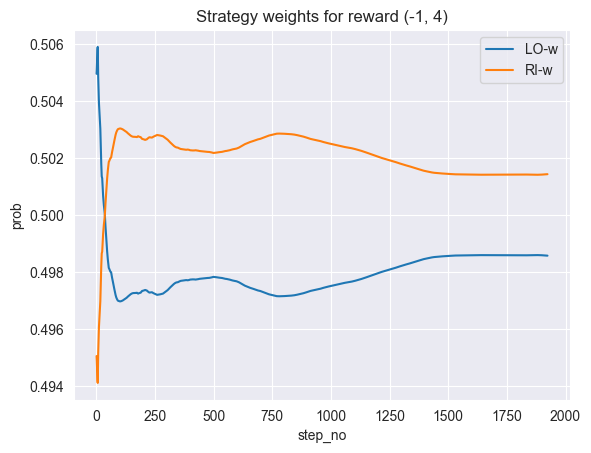

In [10]:
experiment(reward_values=(-1, 4))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 7, 12, 5, 1, 12, 17, 10, 99, 17, 4, 9, 5, 13, 6, 4, 16, 17, 14, 17, 34, 7, 4, 13, 22, 8, 7, 6, 19, 5, 6, 6, 35, 10, 12, 5, 0, 2, 6, 2, 6, 5, 17, 15, 5, 8, 5, 4, 6, 7, 6, 4, 4, 7, 8, 5, 5, 21, 4, 12, 1, 11, 4, 6, 14, 8, 10, 20, 7, 8, 74, 11, 23, 13, 13, 8, 20, 5, 9, 4, 4, 2, 7, 3, 5, 2, 15, 7, 30, 4, 5, 28, 8, 6, 5, 9, 6, 8, 3, 3, 11, 18, 5, 5, 3, 23, 7, 5, 21, 7, 7, 2, 2, 10, 4, 6, 4, 5, 13, 17, 10, 32, 8, 5, 6, 6, 4, 2, 5, 4, 2, 19, 17, 7, 2, 12, 7, 4, 2, 4, 2, 4, 2, 1, 5, 13, 10, 4, 21, 5, 23, 4, 10, 12, 11, 5, 3, 12, 4, 12, 14, 5, 4, 6, 2, 6, 8, 8, 1, 12, 32, 5, 4, 7, 3, 4, 3, 1, 12, 1, 12, 13, 3, 28, 7, 9, 28, 11, 17, 1, 3, 4, 7, 7, 16, 7]


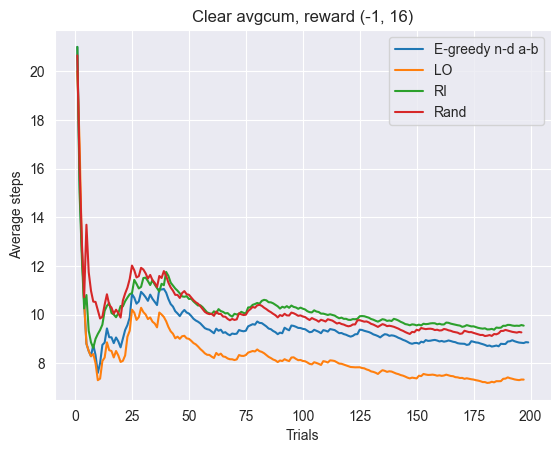

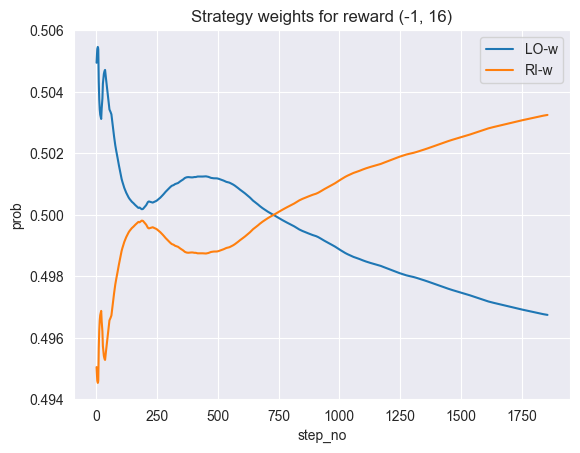

In [11]:
experiment(reward_values=(-1, 16))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 8, 10, 7, 1, 13, 17, 11, 99, 19, 4, 9, 7, 13, 6, 5, 21, 27, 14, 16, 25, 7, 6, 13, 22, 10, 7, 5, 16, 5, 11, 7, 32, 10, 13, 4, 0, 3, 6, 1, 6, 5, 25, 15, 5, 8, 5, 6, 6, 6, 7, 4, 4, 6, 9, 10, 5, 21, 4, 8, 3, 10, 4, 6, 18, 6, 10, 20, 7, 8, 74, 11, 19, 15, 13, 8, 20, 4, 9, 4, 7, 2, 4, 3, 5, 2, 16, 7, 20, 4, 9, 28, 9, 3, 9, 9, 7, 9, 3, 2, 8, 18, 5, 6, 3, 18, 7, 5, 20, 7, 7, 2, 4, 9, 4, 8, 4, 6, 14, 10, 10, 34, 11, 4, 6, 2, 4, 1, 6, 4, 2, 18, 17, 7, 3, 12, 8, 2, 4, 4, 2, 4, 2, 2, 5, 13, 9, 4, 18, 5, 22, 4, 11, 13, 11, 8, 3, 12, 5, 13, 18, 4, 4, 6, 2, 6, 5, 8, 1, 13, 33, 5, 5, 10, 3, 5, 3, 1, 12, 1, 14, 13, 3, 21, 7, 8, 24, 11, 17, 2, 4, 2, 5, 6, 16, 7]


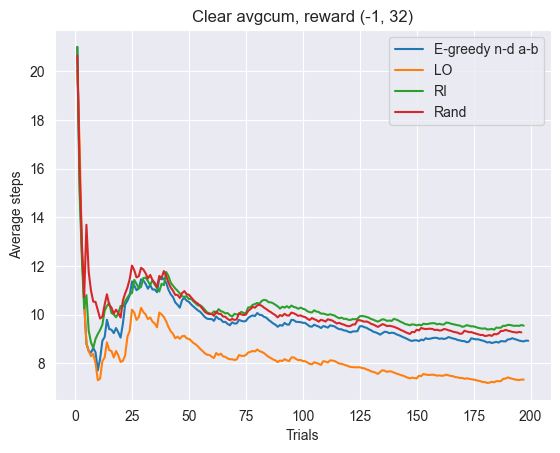

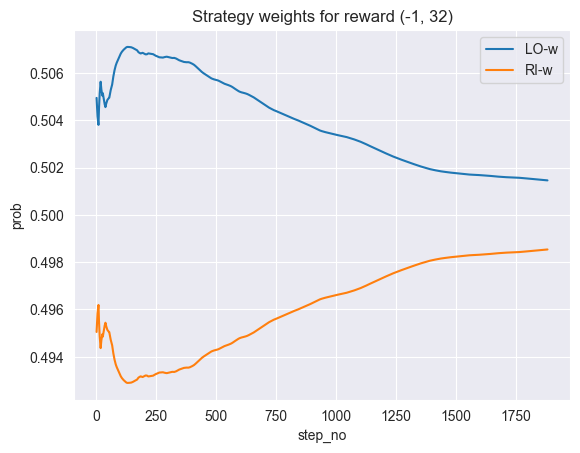

In [12]:
experiment(reward_values=(-1, 32))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 8, 10, 8, 3, 12, 17, 10, 99, 17, 4, 9, 7, 13, 6, 3, 18, 28, 14, 19, 34, 7, 3, 13, 22, 7, 7, 6, 18, 5, 6, 7, 33, 8, 11, 3, 0, 3, 6, 1, 16, 5, 25, 20, 5, 9, 5, 6, 6, 11, 7, 4, 4, 7, 8, 9, 5, 21, 5, 11, 1, 11, 4, 6, 15, 7, 10, 33, 7, 8, 74, 11, 22, 19, 16, 8, 20, 8, 8, 4, 3, 6, 6, 3, 5, 2, 15, 7, 26, 4, 8, 19, 6, 3, 5, 10, 7, 9, 3, 4, 10, 18, 5, 5, 3, 23, 7, 6, 20, 7, 6, 3, 4, 9, 4, 10, 4, 9, 10, 12, 10, 33, 11, 5, 6, 4, 4, 1, 6, 4, 4, 18, 17, 7, 3, 12, 7, 3, 2, 4, 2, 4, 2, 1, 5, 14, 8, 7, 24, 5, 21, 4, 9, 13, 11, 9, 3, 13, 4, 14, 21, 5, 4, 6, 1, 6, 6, 9, 1, 12, 30, 5, 5, 10, 3, 6, 3, 3, 12, 1, 13, 12, 3, 23, 7, 11, 25, 12, 17, 1, 3, 2, 4, 8, 16, 7]


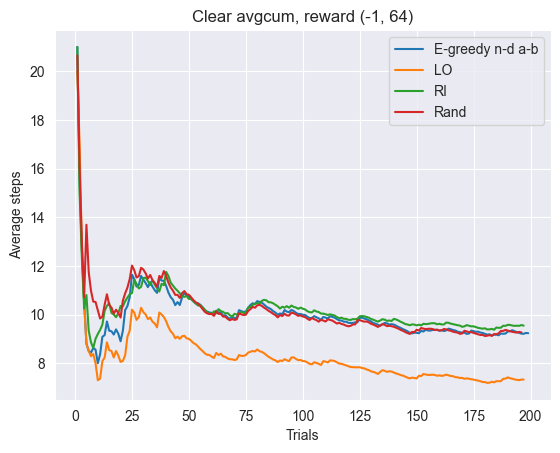

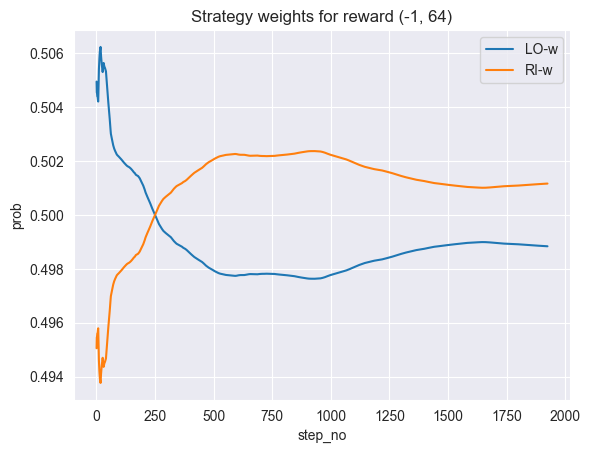

In [13]:
experiment(reward_values=(-1, 64))

Steps eg orig: [21, 10, 7, 4, 43, 2, 7, 7, 10, 8, 1, 12, 17, 13, 99, 12, 4, 10, 6, 13, 8, 5, 14, 19, 19, 19, 20, 7, 2, 13, 22, 5, 7, 5, 18, 5, 11, 6, 24, 10, 10, 4, 0, 4, 5, 1, 10, 5, 18, 17, 5, 11, 5, 6, 6, 8, 3, 4, 4, 6, 8, 8, 5, 21, 4, 12, 2, 11, 4, 6, 18, 6, 10, 28, 7, 8, 52, 11, 22, 14, 16, 8, 19, 4, 8, 4, 5, 11, 5, 3, 5, 2, 13, 7, 23, 4, 7, 28, 9, 3, 5, 9, 7, 8, 3, 2, 11, 18, 5, 6, 3, 23, 7, 6, 25, 7, 7, 2, 4, 14, 4, 5, 4, 7, 14, 11, 10, 36, 8, 4, 6, 3, 5, 3, 6, 3, 1, 17, 17, 7, 3, 12, 7, 6, 6, 4, 2, 4, 2, 1, 5, 13, 11, 4, 17, 5, 21, 4, 11, 9, 11, 8, 3, 12, 5, 12, 16, 4, 4, 6, 2, 6, 4, 9, 1, 12, 33, 5, 5, 10, 4, 4, 6, 3, 9, 1, 13, 12, 3, 28, 7, 8, 25, 13, 17, 1, 4, 2, 4, 6, 16, 5]


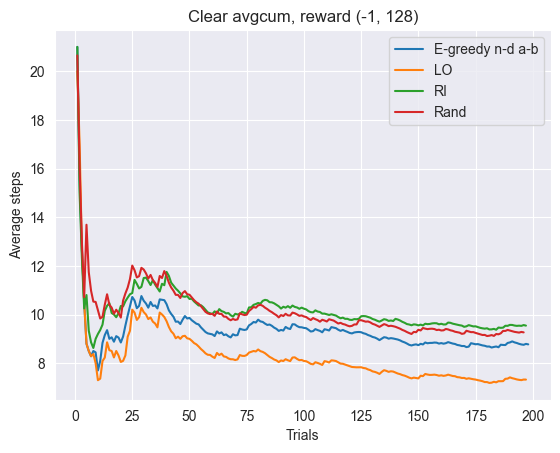

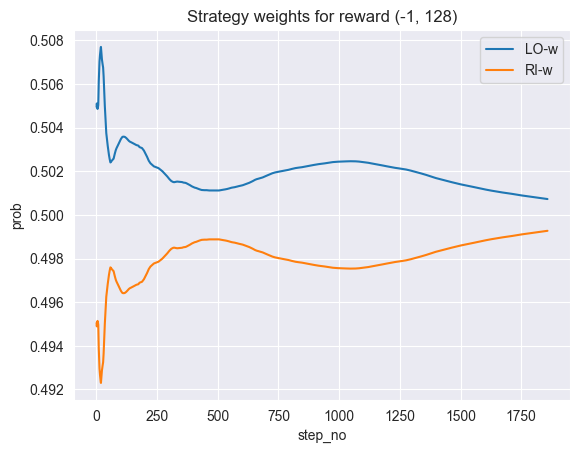

In [14]:
experiment(reward_values=(-1, 128))

In [15]:
reward_values_all = ((-1, 0), (-1, 1), (-1, 2), (-1, 4), (-1, 8), (-1, 9), (-1, 10),
                      (-1, 11), (-1, 12), (-1, 16), (-1, 32), (-1, 64), (-1,100), (-1, 128))

In [17]:
def experiment_v2(reward_values=(-1, 0)):
    env = LambdaEnv(strategies=strategies_env,
                    lambda_terms=terms,
                    max_step_term=max_count_steps_rlenv,
                    count_terms=len(terms),
                    reward_values=(-1, 0))

    _, steps_env = \
        run_e_greedy_policy(environment=env,
                            exploration=explore_actions,
                            max_term_reward=max_count_steps_rlenv,
                            epsilon=epsilon,
                            deterministic=False,
                            is_action_based=True,
                            return_steps=True)
    wh_env = np.array(env.get_weights_history())

    return steps_env, wh_env

def get_expected_steps(data):
    steps = [x for x in data if x != float("inf")]
    steps = [x for x in steps if x != 0]

    distributions = get_common_distributions()
    distributions.remove("expon")
    distributions.remove("cauchy")
    f = Fitter(steps, distributions=distributions)
    f.fit()

    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()
    mu, sigma = f_ln.fitted_param["norm"]
    expected_value = np.e ** (mu + (sigma ** 2) / 2)

    return expected_value, mu, sigma


def draw_wh(wh_env, reward_values):
    comp_data = {
        "LO-w": (wh_env[:, 0], "-"),
        "RI-w": (wh_env[:, 1], "-")
    }
    draw_mult_lines(comp_data, title=f"Strategy weights for reward {reward_values}",
                    x_label="step_no", y_label="prob")

In [18]:
steps_env_all, wh_all = [], []

for rew_values in tqdm(reward_values_all):
    steps_, wh_ = experiment_v2(rew_values)
    steps_env_all.append(steps_)
    wh_all.append(wh_)

100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


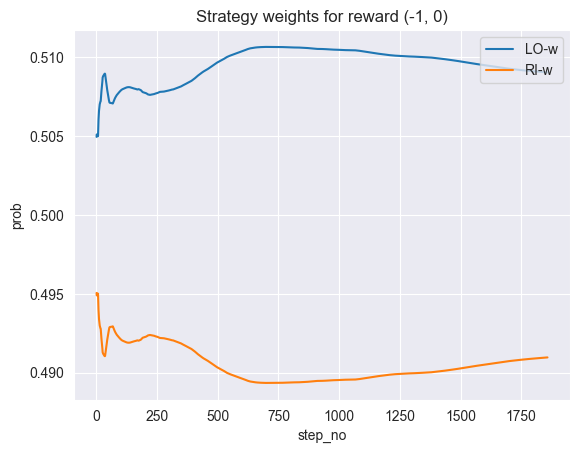

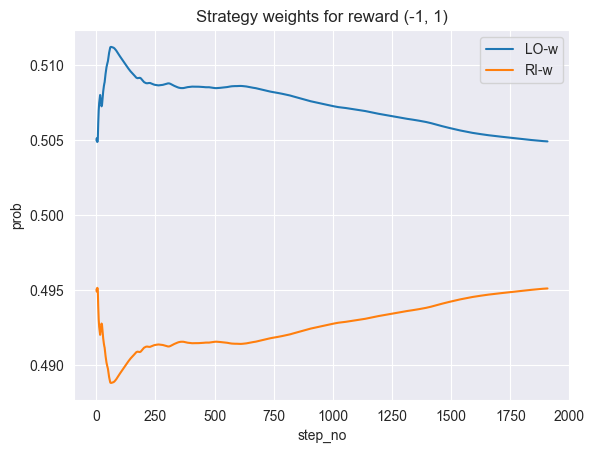

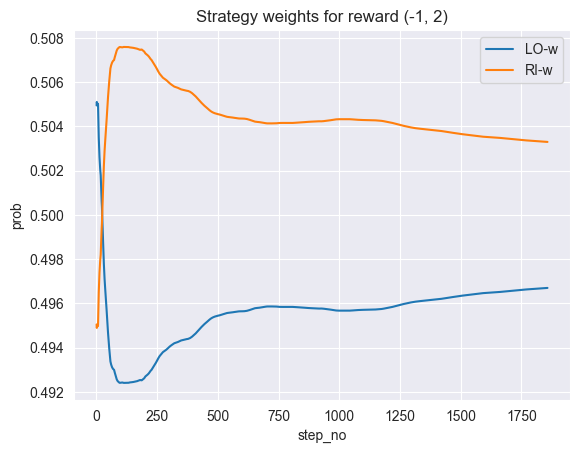

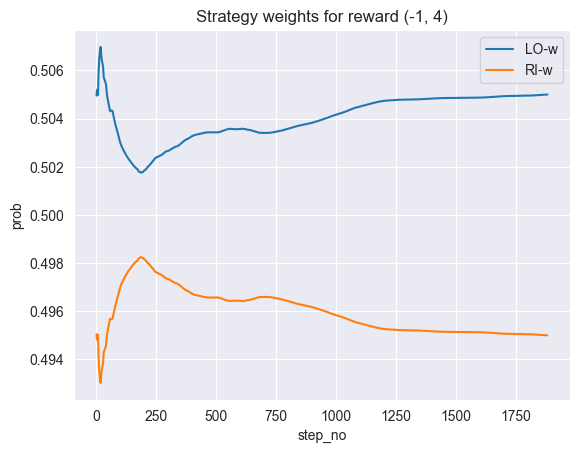

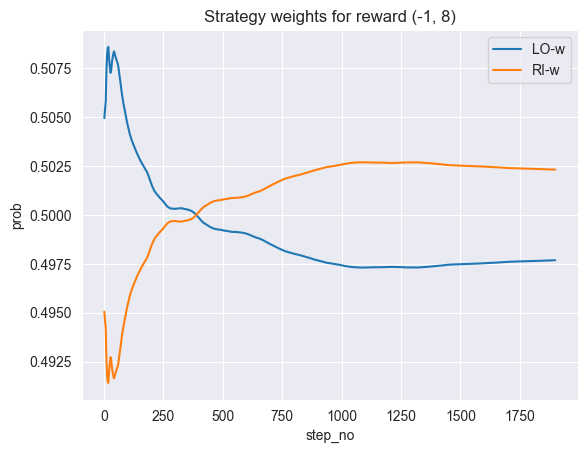

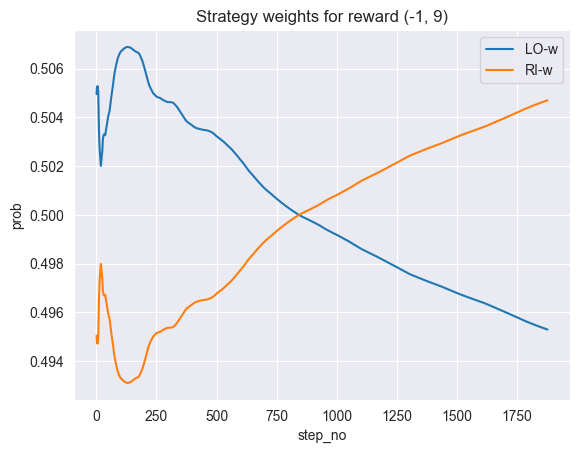

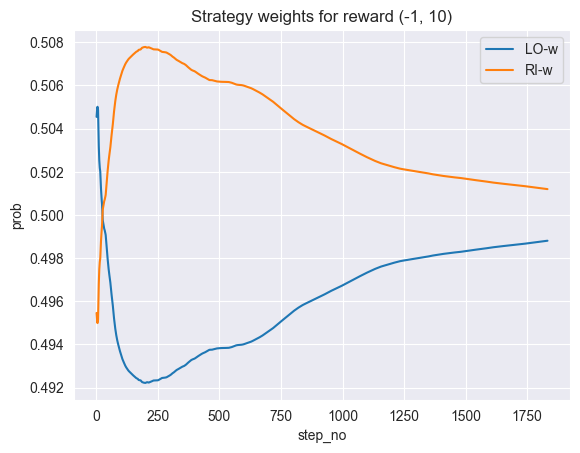

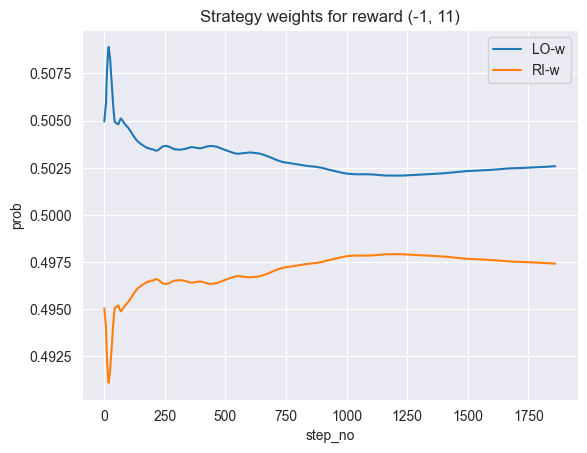

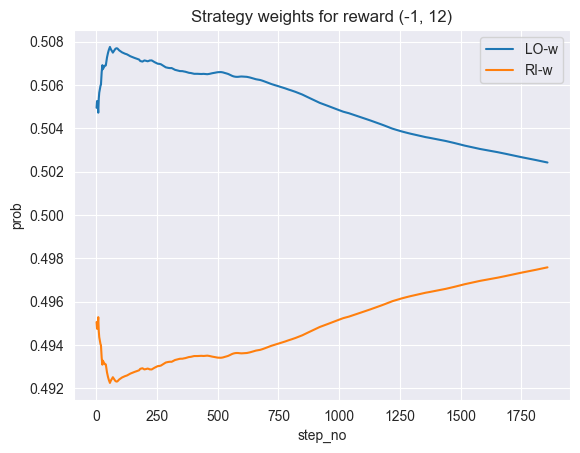

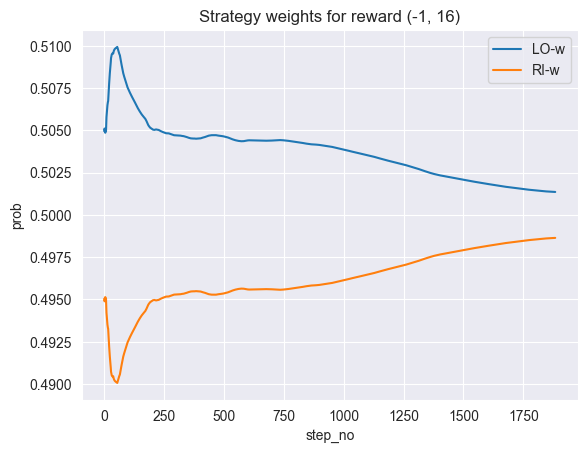

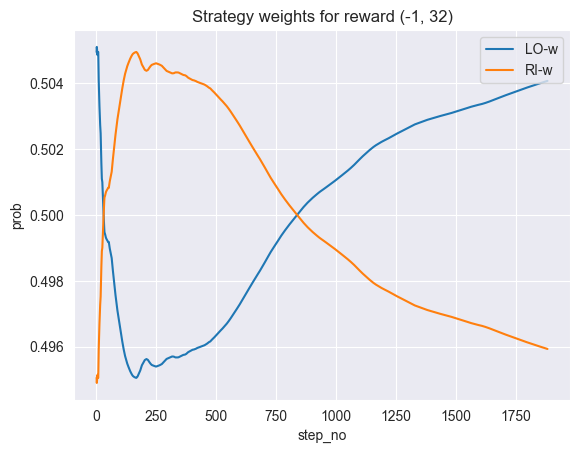

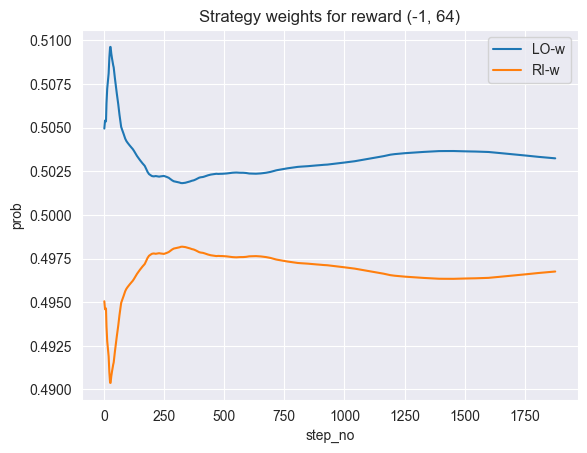

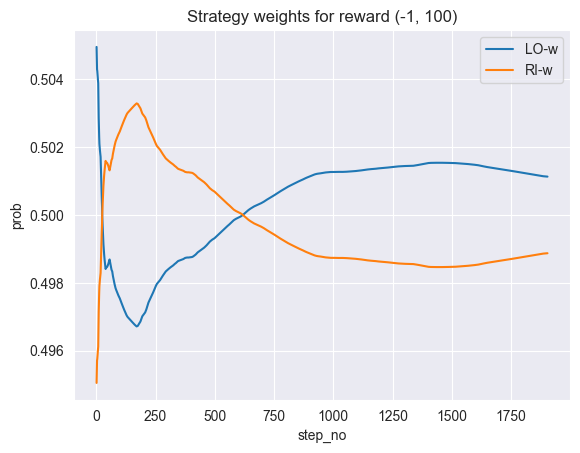

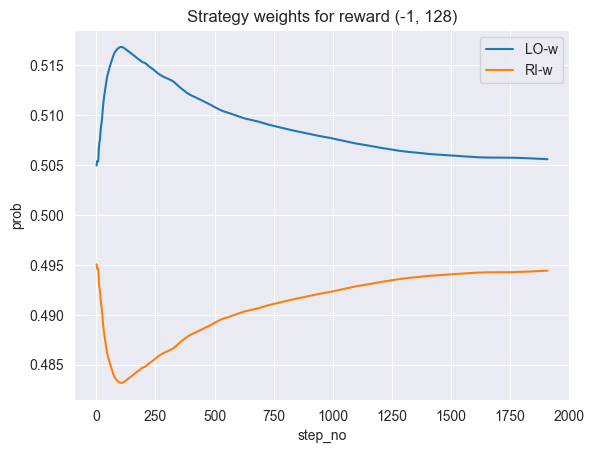

In [19]:
for inx, rew_values in enumerate(reward_values_all):
    draw_wh(wh_env=wh_all[inx], reward_values=rew_values)

In [20]:
expected_value_LO, mu_LO, sigma_LO = get_expected_steps(stepsLO)
expected_value_RI, mu_RI, sigma_RI = get_expected_steps(stepsRI)
expected_value_rand, mu_rand, sigma_rand = get_expected_steps(stepsRand)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 29.30it/s]


In [25]:
expected_value_all, mu_all, sigma_all = [], [], []
for steps_ in steps_env_all:
    expected_value_, mu_, sigma_ = get_expected_steps(clear_arr(steps_))
    expected_value_all.append(expected_value_)
    mu_all.append(mu_)
    sigma_all.append(sigma_)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 24.02it/s]


In [22]:
print(f"LO Log Norm: mu={mu_LO}, sigma={sigma_LO}; expected value={expected_value_LO}")
print(f"RI Log Norm: mu={mu_RI}, sigma={sigma_RI}; expected value={expected_value_RI}")
print(f"Rand Log Norm: mu={mu_rand}, sigma={sigma_rand}; expected value={expected_value_rand}")

LO Log Norm: mu=1.7606532279063747, sigma=0.8455325478849901; expected value=8.315455342099357
RI Log Norm: mu=2.0882889636877247, sigma=0.6066817499740214; expected value=9.701886358621596
Rand Log Norm: mu=2.0267032358235677, sigma=0.7327023147212938; expected value=9.925722072489304


In [26]:
for inx, rew_values in enumerate(reward_values_all):
    print(f"{rew_values} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}")

(-1, 0) Log Norm: mu=1.9307278330652065, sigma=0.7245799390792723; expected value=8.964173196771814
(-1, 1) Log Norm: mu=1.9002265517809813, sigma=0.761437226733428; expected value=8.93628430462995
(-1, 2) Log Norm: mu=1.9155217659924428, sigma=0.7676805236309537; expected value=9.117434495309404
(-1, 4) Log Norm: mu=1.9231916911229279, sigma=0.7551140234228391; expected value=9.100144434390051
(-1, 8) Log Norm: mu=1.9067665474486692, sigma=0.7680434032649951; expected value=9.040476490111194
(-1, 9) Log Norm: mu=1.919715464230509, sigma=0.7369182775426305; expected value=8.94629730832484
(-1, 10) Log Norm: mu=1.9205243167333952, sigma=0.7438953375940799; expected value=8.999908884859748
(-1, 11) Log Norm: mu=1.919883850625832, sigma=0.7541510096969071; expected value=9.06350330290702
(-1, 12) Log Norm: mu=1.9217200566714696, sigma=0.745540128131239; expected value=9.021720854726942
(-1, 16) Log Norm: mu=1.9362138231838837, sigma=0.7493462300469454; expected value=9.17950892714653
(-1,

In [29]:
inx = expected_value_all.index(min(expected_value_all))
print(f"{reward_values_all[inx]} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}")

(-1, 1) Log Norm: mu=1.9002265517809813, sigma=0.761437226733428; expected value=8.93628430462995
